In [3]:
import numpy as np
import scipy
# from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

In [4]:
class Dataset:
    def __init__(self, mu):
        self.ms = np.random.multivariate_normal(mu, np.identity(2), 10)
    def sample(self):
        idx = np.random.choice(len(self.ms))
        return np.random.multivariate_normal(self.ms[idx], np.identity(2)/5)

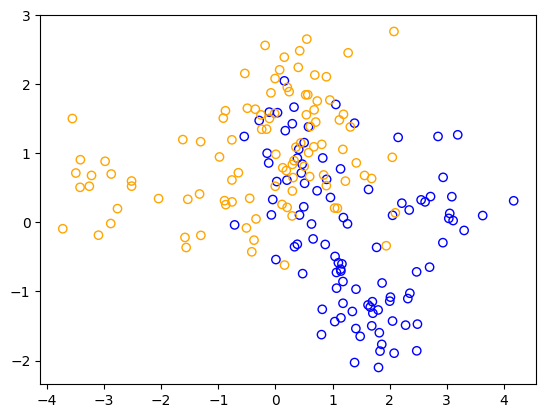

In [5]:
blue = Dataset([1, 0])
orange = Dataset([0, 1])

def generatedata(bn, on):
    def fn(dataset, n, v):
        return np.concatenate(([dataset.sample() for _ in range(n)], np.repeat(v, n).reshape((n, 1))), axis=1)
    return np.concatenate((fn(blue, bn, 0.0), fn(orange, on, 1.0)))

traindata = generatedata(100, 100)
testdata = generatedata(5000, 5000)

# bluesampling = np.array([blue.sample() for _ in range(100)])
# orangesampling = np.array([orange.sample() for _ in range(100)])
def drawdata(data):
    bluelocs = data[:, 2] == 0.0
    orangelocs = data[:, 2] == 1.0
    plt.scatter(data[bluelocs, 0], data[bluelocs, 1], facecolors='none', color='blue')
    plt.scatter(data[orangelocs, 0], data[orangelocs, 1], facecolors='none', color='orange')
drawdata(traindata)

In [6]:
#joinedsampling = np.concatenate((bluesampling, orangesampling))
#joinedoutcome = np.concatenate((np.zeros(len(bluesampling)), np.ones(len(orangesampling))))
#print(f'{len(joinedsampling)=}')
#print(f'{len(joinedoutcome)=}')
print(len(traindata))
print(traindata[:5])

200
[[ 2.55064787  0.32748996  0.        ]
 [ 3.11108389  0.02800884  0.        ]
 [ 1.14665561 -1.38210341  0.        ]
 [ 1.06811212 -0.72430487  0.        ]
 [ 1.07009144 -0.95182814  0.        ]]


In [7]:
model = LinearRegression()
model.fit(traindata[:, :-1], traindata[:, -1])
print(model.coef_, model.intercept_)

[-0.14739932  0.18369436] 0.5040429926969296


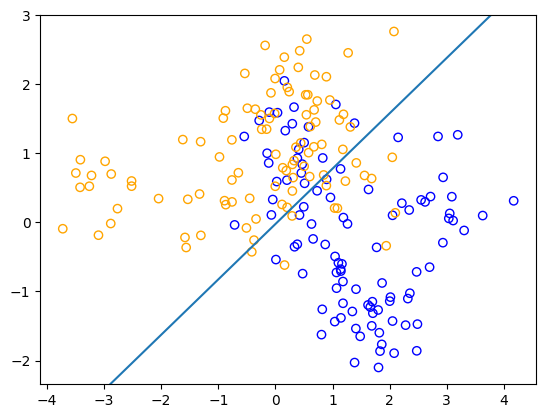

In [8]:
cx, cy = model.coef_
cb = model.intercept_
cb -= 0.5
cy /= cx
cb /= cx
cx /= cx
cy = -cy
cb = -cb
drawdata(traindata)
plt.axline((cb, 0), (cy + cb, 1))

In [9]:
def neighbormodel(n):
    return NearestNeighbors(n_neighbors=n, algorithm='ball_tree').fit(traindata[:, :-1])
def evalpts(model, pts):
    idxs = model.kneighbors(pts, return_distance=False)
    return scipy.stats.mode(traindata[:, -1][idxs], axis=1).mode
# print(evalpts([[0, 0], [1, 1]]))


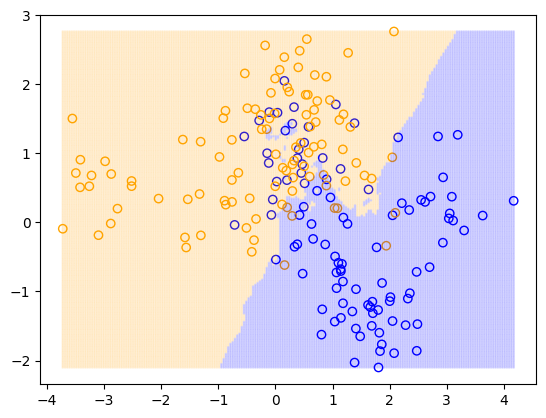

In [10]:
x = np.linspace(np.min(traindata[:, 0]), np.max(traindata[:, 0]), 200)
y = np.linspace(np.min(traindata[:, 1]), np.max(traindata[:, 1]), 200)
xs, ys = np.meshgrid(x, y)
#print(x)
#print(xs)
#print(list(zip(xs, ys)))
pts = np.array(list(zip(xs.ravel(), ys.ravel())))
model = neighbormodel(15)
evals = evalpts(model, pts)
clrs = ['blue' if e < 0.5 else 'orange' for e in evals]

# print(pts[:, 0])

drawdata(traindata)
plt.scatter(pts[:, 0], pts[:, 1], c=clrs, s=1, alpha=0.11)

In [11]:
def accuracy(model, data):
    return (data[:, -1] == evalpts(model, data[:, :-1])).mean()

In [12]:
ks = np.array([151, 101, 69, 45, 31, 21, 11, 7, 5, 3, 1])
trainaccs = []
testaccs = []
for k in ks:
    model = neighbormodel(k)
    trainaccs.append(accuracy(model, traindata))
    testaccs.append(accuracy(model, testdata))
trainaccs = np.array(trainaccs)
testaccs = np.array(testaccs)

[  1.32450331   1.98019802   2.89855072   4.44444444   6.4516129
   9.52380952  18.18181818  28.57142857  40.          66.66666667
 200.        ]


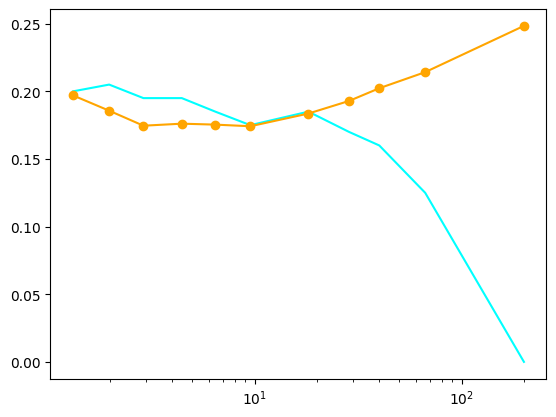

In [13]:
print(len(traindata) / ks)
xs = len(traindata) / ks
plt.semilogx(xs, 1-trainaccs, color='cyan')
plt.semilogx(xs, 1-testaccs, color='orange', marker='o')

Ex 2.1  
  
y is a vector of length N  
sum yi = 1  
claim: $$ argmax_i y_i = argmin_i ||y-t_i|| $$  
$$ argmin_i ||y-t_i|| = $$
$$ argmin_i (y-t_i)^2 = $$
$$ argmin_i y^2 + 1 - 2 \cdot y \cdot t_i = $$
$$ argmin_i -2 \cdot y_i = $$
$$ argmax_i y_i $$

(400, 400)


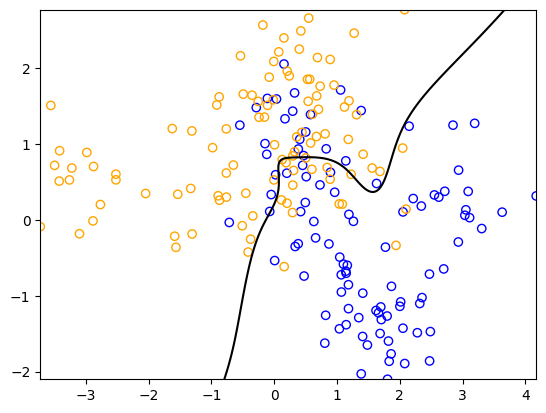

In [14]:
# ex 2.2
# we want to know when do the density functions coincide ?
# assuming ^ to be true, prob need to read up on multivariate distribution/density functions
# density fn = average of normals
# all normals have same matrix
# density = exp(-1/2 (x-mu)t E^-1 (x-mu))/same thing
# exp(-1/2 deltat * 5 * delta)
# exp(-5/2 delta^2)
# we can approx exp with taylor and solve i guess
# we can get points on line with binary search i guess
# exp(-5/2 (x^2 - 2x mux + mux^2 + y^2 - 2y muy + muy^2))
# exp(-5/2 (-2x mux -2y muy + c))
# c * exp(ax + by)
# c exp(ax) exp(by)
# c X^a Y^b
# but ... how do i solve this ...
# dunno, here is a numerical sol

def side(x, y, dataset):
    return np.array([np.exp(-5/2*((x-mx)**2 + (y-my)**2)) for mx,my in dataset.ms]).sum(axis=0)
def delta(x, y):
    return side(x, y, blue) - side(x, y, orange)

x = np.linspace(np.min(traindata[:, 0]), np.max(traindata[:, 0]), 400)
y = np.linspace(np.min(traindata[:, 1]), np.max(traindata[:, 1]), 400)
X, Y = np.meshgrid(x, y)
Z = delta(X, Y)
print(Z.shape)
drawdata(traindata)
plt.contour(X, Y, Z, levels=[0], colors='black')


Ex 2.3  
N data points uniformly picked from p-dimensional unit ball  
$ d(p,N) $ is median of min dist to center  
Need to prove:  
$$ d(p,N) = \left( 1-\frac{1}{2}^{1/N} \right)^{1/p} $$  

let $P(d)$ denote probability of no point having dist to center less than $d$  
$$P(d) = (1 - d^p)^N$$
$$P(d) = 1/2$$
$$(1-d^p)^N=1/2$$
$$1-d^p=1/2^{1/N}$$
$$d^p=1-1/2^{1/N}$$
$$d=(1-1/2^{1/N})^{1/p}$$

Ex 2.4  
$$X \sim N(0,I_p)$$
$$
\newcommand{vx}{\mathbf{x}}
\newcommand{va}{\mathbf{a}}
\newcommand{d}{\mathop{}\!\mathrm{d}}
\begin{align}
E[X^2] &= \int_{\mathbb{R}^p}{\vx^2 \cdot p(\vx) \d \vx} \\
\left[\begin{aligned}
    l &= \| \vx \| \\
    \va &= \vx/l \\
    \vx &= l \cdot \va \\
    D \vx &= \left[ \begin{matrix}
        \dfrac{\partial \vx}{\partial l} & \dfrac{\partial \vx}{\partial \va}
    \end{matrix} \right] \\
    &= \left[\begin{matrix} \va & l \cdot I_p \end{matrix}\right] \\
    J_{\vx}(l,\va) &= \sqrt{\det{D \vx D \vx ^ \intercal}} \\
    &= \sqrt{\det{\left[\begin{matrix}\va & l \cdot I_p\end{matrix}\right]\cdot\left[\begin{matrix}\va^\intercal \\ l \cdot I_p\end{matrix}\right]}} \\
    &= \sqrt{\det{\left( \va \cdot \va^\intercal + l^2 \cdot I_p \right) }} \\
    &= l^{p-1} \cdot \sqrt{1+l^2}
\end{aligned}\right] &= 
\int_{\mathbb{R^+_0} \times S^{p-1}}{l^2 \cdot p(l \cdot \va) \cdot J_{\vx}(l,\va)  \d l \d \va} \\
&= \int{l^2 \cdot p(l \cdot \va) \cdot l^{p-1} \cdot \sqrt{1+l^2} \d l \d \va} \\
&= \int_{R^+_0}{\left( l^2 \cdot l^{p-1} \cdot \sqrt{1+l^2} \d l \cdot \int_{S^{p-1}} p(l \cdot \va)  \d \va \right)} \\
&= \int{ l^{p+1} \cdot \sqrt{1+l^2}  \cdot p(l) \cdot \frac{2 \pi^{p/2}}{\Gamma \left( p/2 \right)} \d l} \\
\left[ p(l) = \frac{e^{ -l^2/2 } }{\left(2 \pi\right)^{p/2}} \right] &=
\int{ l^{p+1} \cdot \sqrt{1+l^2}  \cdot \frac{e^{ -l^2/2 } }{\left(2 \pi\right)^{p/2}} \cdot \frac{2 \pi^{p/2}}{\Gamma \left( p/2 \right)} \d l} \\
&= \int{ l^{p+1} \cdot \sqrt{1+l^2}  \cdot \frac{e^{ -l^2/2 } }{2^{p/2-1}\cdot\Gamma \left( p/2 \right)} \d l} \\
&= \frac{1}{2^{p/2-1}\cdot\Gamma \left( p/2 \right)} \cdot \int{ l^{p+1} \cdot \sqrt{1+l^2}  \cdot e^{ -l^2/2 } \d l} \\
\left[ \begin{aligned}
    t &= l^2 + 1 \\
    \d t &= 2 \d l
\end{aligned} \right] 
&= ...
\end{align}
$$
i give up, restarting  
let $e$ be a $p$-vector of length $1$  
claim: $X \cdot e \sim N(0,1)$  
^ that would prove everything (alongside rotational symmetry of normal distribution)
TODO

Ex 2.5  
TODO

Ex 2.6  
trivial

Ex 2.7  
(a) k-nearest-neighbors trivial  
TODO

In [28]:
# Ex 2.8
def load_cleanup(file):
    data = np.genfromtxt(file, delimiter=' ')
    data = data[(data[:, 0] == 2) | (data[:, 0] == 3)]
    return (data[:, 1:], data[:, 0])

trainx, trainy = load_cleanup('zip.train')
testx, testy = load_cleanup('zip.test')

print(len(trainx), len(testx))

1389 364


In [33]:
lin = LinearRegression()
lin.fit(trainx, trainy)
def eval_lin(datax, datay):
    ykappa = lin.predict(datax)
    ykappa = np.array([2 if y < 2.5 else 3 for y in ykappa])
    return (datay == ykappa).mean()
# print(testy)
print(eval_lin(trainx, trainy) * 100)
print(eval_lin(testx, testy) * 100)

99.4240460763139
95.87912087912088


In [140]:
def knmodel(k):
    return NearestNeighbors(n_neighbors=k).fit(trainx)

def kn_eval(model, datax, datay):
    idxs = model.kneighbors(datax, return_distance=False)
    return (scipy.stats.mode(trainy[idxs], axis=1).mode == datay).mean()

for k in [1, 3, 5, 7, 15]:
    model = knmodel(k)
    print(k, kn_eval(model, trainx, trainy)*100, kn_eval(model, testx, testy)*100)

1 100.0 97.52747252747253
3 99.49604031677465 96.97802197802197
5 99.4240460763139 96.97802197802197
7 99.35205183585313 96.7032967032967
15 99.06407487401007 96.15384615384616


In [153]:

def in_sample_MSE(n):
    xs = np.random.choice(np.arange(10), n).reshape((n, 1))
    ys = np.random.binomial(3, 0.5, n)
    ys += xs[:,0]*xs[:,0]
    # print(xs)
    # print(ys)
    lin = LinearRegression()
    lin.fit(xs, ys)
    yks = lin.predict(xs)
    return ((ys-yks)**2).mean()

last = -1
for n in 2**np.arange(15):
    curr = np.array([in_sample_MSE(n) for _ in range(1000)]).mean()
    print(n, (curr > last), curr)
    last = curr

1 True 0.0
2 True 0.03675
4 True 18.449356515194587
8 True 35.91759496481654
16 True 44.15185284873207
32 True 49.30492305914042
64 True 51.51286918275191
128 True 52.40092023226259
256 True 53.03912558384823
512 True 53.192402085716495
1024 True 53.4951220268132
2048 False 53.42672079571511
4096 True 53.49962058890713
8192 True 53.53164847560048
16384 True 53.564498468310596



E Rtr BetaTr <= E Rtest BetaTr
M = N

E 1/N Suma(BetaTr, tr) <?= E 1/2N ( Suma(BetaTr, test U tr) )
RHS >!= E 1/2N ( Suma(BetaTrTest, test U tr) )

F(n) = E MSE na N sampleova
LHS = F(N)
RHS >= F(2N)
dovoljno pokazati F(2N) >= F(N)

F(2N) = E 1/2N minimum_beta {suma 2N elemenata od (y-beta*x)^2}

minimum_beta {suma 2N elemenata od (y-beta*x)^2}
= minimum_beta_N + minimum_beta_N

F(2N) = E 1/2N minimum_beta {suma 2N elemenata od (y-beta*x)^2}
. >= E 1/2N ( minimum_beta_1..N + minimum_beta_N+1..2N )
. == F(N)/2 + F(N)/2 == F(N)

F(N+1) >= F(N)

$
\begin{align}
MSE(x_0) &= E_T[f(x_0) - y]
\end{align}
$